In [2]:
# numpy and plotting
import numpy as np
# import pylab
# import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# pyFAI
import pyFAI
# pygix
import pygix
import fabio
import pandas as pd
from pathlib import Path
np.seterr(divide = 'ignore') 
# %matplotlib widget

c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

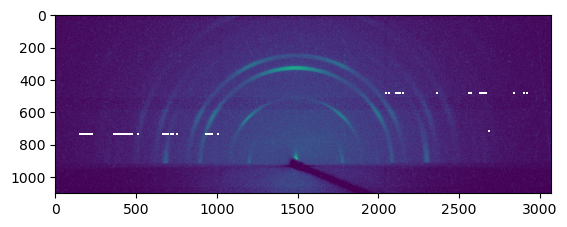

In [16]:
### Load the image data from the tiff. This notebook will need to be in the same folder as the tiff and .poni file
directory = Path("C:\\Users\\Teddy\OneDrive - UCB-O365\\Rogerslab3\\Teddy\\TPP Films\\BTB-TPP\\2024 Film Growth\\Film 1\\GIWAXS TT5-06")
filename = "GIWAXS-30min-BTBaTPP-teddy-20240130"
data = fabio.open(directory / (filename + ".tif")).data

"""pylab.close('all')

fig=pylab.figure(); gs = gridspec.GridSpec(1, 1); ax1 = plt.subplot(gs[0,0])
for ax in fig.get_axes():
    ax.tick_params(which='both', color='k'); #ax.set_facecolor(LBLU)
ax1.set_xlabel("x-pixel (#)"); ax1.set_ylabel("y-pixel (#)"); ax1.yaxis.set_ticks_position('both'); ax1.xaxis.set_ticks_position('both');# ax1.set_facecolor(LBLU)

ax1.imshow(np.log(data), vmin=1, vmax=8, origin='lower')"""

plt.imshow(np.log10(data + 1))


In [17]:
### Load the poni file that the extraction code wrote from the .rasx file. This is used to correct the data.
pg = pygix.Transform()
pg.load(directory / "cal.poni")
### Load the poni file that the extraction code wrote from the .rasx file

Detector Detector	 PixelSize= 7.500e-05, 7.500e-05 m	 TopLeft (1)
Wavelength= 1.541850e-10 m
SampleDetDist= 1.390234e-01 m	PONI= 1.281487e-02, 1.184019e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 139.023 mm	Center: x=1578.692, y=170.865 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.542Å

In [18]:
pg.sample_orientation = 1    # 1 is horizontal, 2 is vertical, 3 is 1*180 deg, 4 is 2*180 deg
pg.incident_angle = .25   # incident angle in deg - should be output from the extraction code
pg # optionally print geometry

Detector Detector	 PixelSize= 7.500e-05, 7.500e-05 m	 TopLeft (1)
Wavelength= 1.541850e-10 m
SampleDetDist= 1.390234e-01 m	PONI= 1.281487e-02, 1.184019e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 139.023 mm	Center: x=1578.692, y=170.865 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.542Å

: 

c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pygix-0.1.4a0-py3.11.egg\pygix\transform.py:1032: UserWarning: The keyword 'pos0Range' is deprecated in favor of 'pos0_range'
  I, bins_x, bins_y, sum, count = splitBBox.histoBBox2d(
c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pygix-0.1.4a0-py3.11.egg\pygix\transform.py:1032: UserWarning: The keyword 'pos1Range' is deprecated in favor of 'pos1_range'
  I, bins_x, bins_y, sum, count = splitBBox.histoBBox2d(


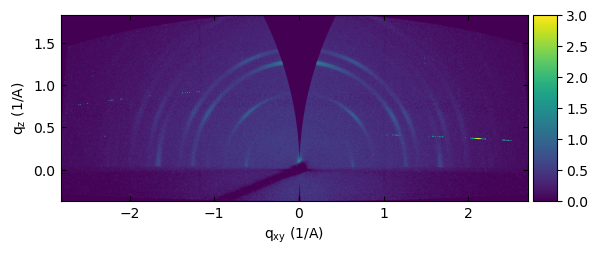

In [15]:
from PIL import Image
### Transform the data using the grazing incidence correction
ii_2d, qxy_2d, qz_2d = pg.transform_reciprocal(data, mask=None, method = 'bbox')

"""### Now plot
close('all')

fig=figure(facecolor = 'w') 

gs = gridspec.GridSpec(1, 1); ax1 = plt.subplot(gs[0,0])
for ax in fig.get_axes():
    ax.tick_params(which='both', color='k', direction = 'in'); #ax.set_facecolor(LBLU)
ax1.set_xlabel("q$_\mathregular{xy}$ (1/A)"); ax1.set_ylabel("q$_\mathregular{z}$ (1/A)"); ax1.yaxis.set_ticks_position('both'); ax1.xaxis.set_ticks_position('both')

pos = ax1.imshow(np.log(ii_2d),
           extent=(np.min(qxy_2d)/10,np.max(qxy_2d)/10,-np.max(qz_2d)/10,-np.min(qz_2d)/10),
           vmin = 0, vmax = 3)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(pos, cax=cax)"""

fig = plt.figure(facecolor="w")

gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0, 0])
for ax in fig.get_axes():
    ax.tick_params(which='both', color='k', direction = 'in')
    ax.set_facecolor("b")
ax1.set_xlabel("q$_\mathregular{xy}$ (1/A)")
ax1.set_ylabel("q$_\mathregular{z}$ (1/A)")
ax1.yaxis.set_ticks_position('both'); ax1.xaxis.set_ticks_position('both')
pos = ax1.imshow(np.log10(ii_2d + 1),
           extent=(np.min(qxy_2d)/10, np.max(qxy_2d)/10, -np.max(qz_2d)/10, -np.min(qz_2d)/10),
           vmin = 0, vmax = 3)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(pos, cax=cax)

def save_tiff(filename, image_array):
    im = Image.fromarray(image_array)
    im.save(filename)

save_tiff(directory / (filename + "_transform.tif"), )
